
# A Demonstration of Jupyter Notebooks

<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://raw.githubusercontent.com/jupyter/nature-demo/master/images/jupyter-logo.png" width="150px">
</div>

Roadmap for workflow:
* Get lay of the land
* Build a custom BLAST database to verify identity
* Investigate one of these sequences closer by building a tree
* Get the specimen data spreadsheet ready for GenBank upload

## Get the lay of the land

In a Jupyter notebook, you can run shell commands directly by leading with a "!". Here we'll run the *pwd* command to check our current directory.

In [7]:
!pwd

/Users/miketrizna/Dropbox (Smithsonian)/genomic_tools_talk


In [8]:
!ls -al

total 35488
drwxr-xr-x@ 12 miketrizna  staff       408 Mar 24 13:05 .
drwx------@ 35 miketrizna  staff      1190 Mar 24 12:57 ..
-rw-r--r--@  1 miketrizna  staff     12292 Mar 24 12:54 .DS_Store
drwxr-xr-x@  4 miketrizna  staff       136 Mar 24 12:54 .ipynb_checkpoints
-rw-r--r--@  1 miketrizna  staff      2349 Mar 24 12:33 Bash and R testing.ipynb
-rw-r--r--@  1 miketrizna  staff     57746 Mar 24 13:05 First Draft of Talk.ipynb
-rw-r--r--@  1 miketrizna  staff  17981114 Mar 24 09:12 all_bird_coi.fasta
drwxr-xr-x@  9 miketrizna  staff       306 Mar 24 12:10 analysis
drwxr-xr-x@ 21 miketrizna  staff       714 Mar 24 10:15 blast_db
-rw-r--r--@  1 miketrizna  staff    102893 Mar 23 15:38 gbif_djibouti_birds.csv
drwxr-xr-x@ 10 miketrizna  staff       340 Mar 24 12:37 genbank_upload
drwxr-xr-x@  3 miketrizna  staff       102 Mar 24 10:31 original_data


In addition to with the "!", we can run bash commands by starting a cell with "%%bash".

In [10]:
%%bash
ls -al original_data

total 8
drwxr-xr-x@  3 miketrizna  staff   102 Mar 24 10:31 .
drwxr-xr-x@ 12 miketrizna  staff   408 Mar 24 13:09 ..
-rw-r--r--@  1 miketrizna  staff  3421 Mar 24 10:26 five_barcodes.fasta


Furthermore, we can create python variables, and then bring them into the bash cells by initializing with "-s"

In [22]:
input_sequences = "original_data/five_barcodes.fasta"
input_specimen_data = "original_data/barcode_specimen_data.tsv"

In [14]:
%%bash -s "$input_sequences"
head -n 4 $1

>647813|Ciconia_abdimii
ACCTTATACTTGATCTTCGGAGCATGAGCCGGCATAGTCGGAACCGCCCTCAGCCTCCTTATTCGTGCAGAACTTGGCCAACCAGGGACCCTCTTAGGAGACGACCAAATCTATAACGTAATCGTCACCGCCCATGCCTTCGTAATAATCTTCTTCATAGTCATACCAATCATAATCGGAGGATTCGGAAACTGATTAGTCCCGCTCATAATTGGTGCCCCAGACATAGCATTCCCACGCATAAACAACATAAGCTTCTGATTACTACCCCCATCCTTCTTACTCCTACTGGCCTCCTCCACAGTAGAAGCAGGAGCAGGTACAGGATGGACCGTATACCCTCCCCTAGCCGGCAATCTAGCCCACGCTGGAGCTTCAGTAGACCTAGCCATCTTCTCCCTCCACCTAGCAGGTGTATCCTCAATTCTCGGAGCGATCAACTTTATCACAACTGCCATCAACATAAAACCTCCTGCCCTATCACAATACCAAACCCCCCTATTCGTATGGTCCGTCCTCATCACCGCTGTCCTCCTACTACTATCACTCCCAGTCCTTGCTGCTGGCATCACCATGCTACTAACAGATCGAAACCTAAACACCACATTCTTTGACCCCGCTGGAGGAGGAGACCCTGTCCTATACCAGCACCTCTTC
>647841|Pluvialis_squatarola
ACCCTATACCTAATCTTCGGTGCATGAGCTGGTATAGTCGGTACCGCCCTTAGCCTACTCATCCGCGCAGAACTCGGTCAACCAGGTACCCTACTAGGAGACGACCAAATCTACAATGTAATTGTTACCGCCCATGCCTTCGTAATAATCTTCTTCATAGTCATGCCAATCATGATTGGAGGCTTTGGAAACTGACTAGTACCACTCATAATTGGTGCCCCCGACATAGCATTTCCCCGCATAAACAACATAAGCTTCTGGCTACTTCCCCCATCGTTCCTACTCCTCC

## Build a custom BLAST database to verify identity

In a lot of DNA barcoding projects, we already know the identity of the tissues before sequencing, so we BLAST our sequences against GenBank to confirm we didn't have contamination, or flag specimens that take a closer look at. We could BLAST against the full GenBank database, but that can take a long time. Since we already know the region sequenced (mitochondrial COI gene), and the general taxonomic group (Birds), let's create our own local BLAST database.

We're going to be using the Entrez Direct command line tools to grab these sequences. You can read about them here: http://www.ncbi.nlm.nih.gov/books/NBK179288/

In [15]:
from IPython.display import IFrame
IFrame('http://www.ncbi.nlm.nih.gov/books/NBK179288/', width='90%', height=350)

Since we're going to be refering to these input and output files a lot during this demo, let's just put them into variables now.

In [17]:
blast_db_fasta = "blast_db/all_bird_coi.fasta"

blast_db_title = "all_bird_coi"
blast_db_location = "blast_db/" + blast_db_title

**SKIP RUNNING THIS CELL BELOW DURING LIVE DEMO**

Here, we use the *esearch* tool to search the NCBI "nuccore" database, with a query for all COI gene sequences that are less than 1000 base pairs (so that we don't grab full mitochondria) from the class Aves. We then pipe the search results into the *efetch* tool, and tell it we want our data in FASTA format, and finally save it all to the "all_bird_coi.fasta" file that we just named.


In [9]:
%%bash -s "$blast_db_fasta"
esearch -db nuccore -query "Aves[ORGANISM] AND COI[GENE] AND 0:1000[SLEN]" \
        -datetype PDAT -mindate 1990 -maxdate 2015 | \
efetch -format fasta | \
grep "." > \
$1

Ok, now that we've grabbed all bird COI sequences into a FASTA file, let's check to make sure it worked correctly. This strange "grep" and "wc" command counts the number of ">" characters in a file, which we can use to count the number of sequences in a FASTA-format file.

In [13]:
%%bash -s "$blast_db_fasta"
grep ">" -o $1 | wc -l

   24121


In [14]:
%%bash -s "$blast_db_fasta"
head $1

>gi|817250091|emb|LN734648.1| Cuculus canorus mitochondrial partial COI gene for cytochrome oxidase subunit 1, specimen voucher NHMUK 1996-1-126
TAAAACCTCCCGCACTGTCTCAATACCAAACACCCCTATTCGTATGATCAGTACTTATCACCGCTGTCCT
ACTCCTATTATCTCTACCCGTACTAGCCGCTGGCATCACGATACTACTAACAGACCGCAACCTAAACACC
ACATTCTTCGACCCAGCAG
>gi|817250088|emb|LN734647.1| Cuculus canorus mitochondrial partial COI gene for cytochrome oxidase subunit 1, specimen voucher NHMUK 1925-12-15-5852
TAAAACCTCCCGCACTGTCTCAATACCAAACACCCCTATTCGTATGATCAGTACTTATCACCGCTGTCCT
ACTCCTATTATCTCTACCCGTACTAGCCGCTGGCATCACGATACTACTAACAGACCGCAACCTAAACACC
ACATTCTTCGACCCAGCAG
>gi|817250084|emb|LN734646.1| Cuculus canorus mitochondrial partial COI gene for cytochrome oxidase subunit 1, specimen voucher NHMUK Baker-Box48-D2
TAAAACCTCCCGCACTGTCTCAATACCAAACACCCCTATTCGTATGATCAGTACTTATCACCGCTGTCCT


Ok, now that we've got our FASTA in place, let's move on to making a custom database from it. We'll use the BLAST+ tool *makeblastdb* to do this.

In [16]:
!makeblastdb -h

USAGE
  makeblastdb [-h] [-help] [-in input_file] [-input_type type]
    -dbtype molecule_type [-title database_title] [-parse_seqids]
    [-hash_index] [-mask_data mask_data_files] [-mask_id mask_algo_ids]
    [-mask_desc mask_algo_descriptions] [-gi_mask]
    [-gi_mask_name gi_based_mask_names] [-out database_name]
    [-max_file_sz number_of_bytes] [-logfile File_Name] [-taxid TaxID]
    [-taxid_map TaxIDMapFile] [-version]

DESCRIPTION
   Application to create BLAST databases, version 2.2.31+

Use '-help' to print detailed descriptions of command line arguments


Here we create the custom BLAST database, and save it to the "blast_db" directory.

In [18]:
%%bash -s "$blast_db_fasta" "$blast_db_title" "$blast_db_location"
makeblastdb -in $1 -parse_seqids -dbtype nucl -title $2 -out $3



Building a new DB, current time: 03/24/2016 13:21:19
New DB name:   /Users/miketrizna/Dropbox (Smithsonian)/genomic_tools_talk/blast_db/all_bird_coi
New DB title:  all_bird_coi
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 22901 sequences in 1.26028 seconds.


Awesome, now the custom blast database has been built, and it's location is in a bunch of files in the "blast_db" directory.

In [19]:
! ls -al blast_db

total 52944
drwxr-xr-x@ 12 miketrizna  staff       408 Mar 24 13:21 .
drwxr-xr-x@ 12 miketrizna  staff       408 Mar 24 13:19 ..
-rw-r--r--@  1 miketrizna  staff      6148 Mar 24 13:21 .DS_Store
-rw-r--r--@  1 miketrizna  staff  18060240 Mar 24 09:26 all_bird_coi.fasta
-rw-r--r--@  1 miketrizna  staff   4024666 Mar 24 13:21 all_bird_coi.nhr
-rw-r--r--@  1 miketrizna  staff    274896 Mar 24 13:21 all_bird_coi.nin
-rw-r--r--@  1 miketrizna  staff    183208 Mar 24 13:21 all_bird_coi.nnd
-rw-r--r--@  1 miketrizna  staff       764 Mar 24 13:21 all_bird_coi.nni
-rw-r--r--@  1 miketrizna  staff     91636 Mar 24 13:21 all_bird_coi.nog
-rw-r--r--@  1 miketrizna  staff    711026 Mar 24 13:21 all_bird_coi.nsd
-rw-r--r--@  1 miketrizna  staff     16661 Mar 24 13:21 all_bird_coi.nsi
-rw-r--r--@  1 miketrizna  staff   3714235 Mar 24 13:21 all_bird_coi.nsq


Finally, let's BLAST our original FASTA file against the custom database we just built.

The newer version of BLAST include a really helpful feature where we can make the results go into a tab-delimited table (outfmt 6), and we can specify the columns we want to see. Here we specify the Query Sequence ID (qseqid), Subject Accession (sacc), Subject Title (stitle), Percent Identity (pident), and Alignment Length (length).

In [28]:
blast_results_location = "analysis/blast_results.tsv"

In [29]:
%%bash -s "$input_sequences" "$blast_db_location" "$blast_results_location"
blastn -query $1 -db $2 -out $3 \
       -max_target_seqs 5 \
       -outfmt "6 qseqid sacc stitle pident length"

In [31]:
%%bash -s "$blast_results_location"
head $1

647813|Ciconia_abdimii	JQ174455	Ciconia maguari voucher USNM:Birds:635735 cytochrome oxidase subunit 1 (COI) gene, partial cds; mitochondrial	92.77	650
647813|Ciconia_abdimii	JQ174456	Ciconia maguari voucher USNM:Birds:614527 cytochrome oxidase subunit 1 (COI) gene, partial cds; mitochondrial	92.77	650
647813|Ciconia_abdimii	JQ174457	Ciconia maguari voucher USNM:Birds:614526 cytochrome oxidase subunit 1 (COI) gene, partial cds; mitochondrial	92.77	650
647813|Ciconia_abdimii	JQ174458	Ciconia maguari voucher USNM:Birds:635750 cytochrome oxidase subunit 1 (COI) gene, partial cds; mitochondrial	92.77	650
647813|Ciconia_abdimii	FJ027377	Ciconia maguari voucher MACN-Or-ct 2356 cytochrome oxidase subunit 1 (COI) gene, partial cds; mitochondrial	92.87	645
647841|Pluvialis_squatarola	GQ482511	Pluvialis squatarola voucher UWBM 43964 cytochrome oxidase subunit 1 (COI) gene, partial cds; mitochondrial	100.00	655
647841|Pluvialis_squatarola	GQ482512	Pluvialis squatarola voucher UWBM 44500 cytochrom

In [35]:
# Use a little bit of Python csv parsing to cycle through results and highlight mismatches
import csv
import pandas as pd

## Investigate one of these sequences closer by building a tree

Since that first Ciconia sequence seems a little bit off, let's grab all of the Ciconia COI sequences from GenBank to see if our sequence is falling in the proper place.

In [29]:
ciconia_tsv = "analysis/all_ciconia_coi.tsv"
ciconia_fasta = "analysis/all_ciconia_coi.fasta"

In [33]:
%%bash -s "$ciconia_tsv"
esearch -db nuccore -query "Ciconia[ORGANISM] AND COI[GENE] AND 0:1000[SLEN]" \
        -datetype PDAT -mindate 1990 -maxdate 2015 | \
efetch -format fasta -mode xml | \
xtract -pattern TSeq -element TSeq_accver TSeq_orgname TSeq_sequence \
> $1

Since the edirect *xtract* utility will only output into a Tab-delimited text file, we'll need to use a little scripting to convert that to FASTA format.

In [40]:
with open(ciconia_fasta,'wb') as fasta_out:
    with open(ciconia_tsv,'rb') as tsv_in:
        reader = csv.reader(tsv_in, delimiter="\t")
        for row in reader:
            accession, org_name, sequence = row[0],row[1],row[2]
            org_name = org_name.replace(" ","_")
            fasta_entry = ">{accession}|{org_name}\n{sequence}\n".format(accession=accession,
                                                                         org_name=org_name,
                                                                         sequence=sequence)
            fasta_out.write(fasta_entry)

Now we need to add the first sequence from our original FASTA (all in the first 2 lines) to the end of the Ciconia FASTA we just built.

In [30]:
%%bash -s "$input_sequences" "$ciconia_fasta"
head -n 2 $1 >> $2

Ok, now that we have all known Ciconia COI sequences, and our suspect sequence in one file, let's align it and then make a tree. We'll use *muscle* to run the alignment.

In [1]:
aligned_fasta = "analysis/ciconia_aligned.fasta"

In [41]:
%%bash -s "$ciconia_fasta" "$aligned_fasta"
muscle -in $1 -out $2


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

all_ciconia_coi 14 seqs, lengths min 648, max 674, avg 652
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00      1 MB(0%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00      8 MB(0%)  Iter   1  100.00%  Align node
00:00:00      8 MB(0%)  Iter   1  100.00%  Root alignment
00:00:00      8 MB(0%)  Iter   2  100.00%  Root alignment
00:00:01      9 MB(0%)  Iter   3  100.00%  Refine biparts


**Use BioJup widget to visualize multiple alignment**

Now we use *fasttree* to take the alignment, and produce a quick neighbor-joining tree.

In [4]:
tree_file = "analysis/ciconia_tree.newick"

In [45]:
%%bash -s "$aligned_fasta" "$tree_file"
fasttree -nt $1 > $2

FastTree Version 2.1.8 Double precision (No SSE3)
Alignment: analysis/ciconia_aligned.fasta
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jukes-Cantor, CAT approximation with 20 rate categories
Ignored unknown character X (seen 2 times)
Initial topology in 0.00 seconds
Refining topology: 11 rounds ME-NNIs, 2 rounds ME-SPRs, 6 rounds ML-NNIs
Total branch-length 0.174 after 0.01 sec
ML-NNI round 1: LogLk = -1856.072 NNIs 0 max delta 0.00 Time 0.02
Switched to using 20 rate categories (CAT approximation)
Rate categories were divided by 0.651 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -1818.450 NNIs 0 max delta 0.00 Time 0.02
Turning off heuristics for final round of ML NNIs (converged)
ML-NNI round 3: LogLk = 

Next, we'll use the ETE Python Toolkit to generate a tree right here in the Notebook. Here's a link to ETE: http://etetoolkit.org/

In [5]:
# Use ete3 to load that tree, style our target sequence node to stand out, and then output tree
from ete3 import Tree, TreeStyle

t = Tree(newick = tree_file)

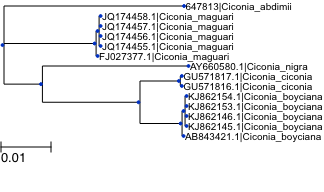

In [6]:
ts = TreeStyle()
t.render("%%inline",tree_style=ts)

## Get the specimen data spreadsheet ready for GenBank upload

In [10]:
# Read csv in using R -- hopefully dropping unnecessary columns right away

In [11]:
# Now drop unnecessary rows

In [12]:
# Perform any necessary transformations, like collection date and/or lat_lon formatting

In [13]:
# Export in whatever format is required

## Finally, package all together to submit to GenBank

We've finally come to the part where we put everything together, and make a GenBank submission package! We'll be using *tbl2asn* to do this. You can read more about it here: http://www.ncbi.nlm.nih.gov/genbank/tbl2asn2/

Based on the documentation, we're going to need 4 different files that *tbl2asn* will wrap together into our submission:

* A "template file", which contains all of the submitter contact information, and also sequence authorship (suffix .sbt). NCBI has a website where you can fill out a form, and it will generate one for you: https://submit.ncbi.nlm.nih.gov/genbank/template/submission/
* Nucleotide sequence data in FASTA format (suffix .fsa).
* A "feature table", which contains the sequence annotations, such as gene and CDS data (suffix .tbl)
* A "source modifiers table", which is a tab-delimited table that contains all of the specimen metadata for your sequences (suffix .src)


In [1]:
%%bash
tbl2asn -t genbank_upload/template.sbt -p genbank_upload -V vb -a s

[tbl2asn 24.9] Flatfile barcodes_to_submit

[tbl2asn 24.9] Validating barcodes_to_submit

